In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

In [2]:
class DynSys:
    def __init__(self, param):
        self.param = param
        N_DATA, N_NODE, ALPHA = param['N_DATA'], param['N_NODE'], param['ALPHA']
        T, STD = param['T'], param['STD']
        
        #ALPHA_RAND = np.linspace(ALPHA, 1.0, N_NODE)

        ################################
        # Create Interaction matrix
        ################################
        self.M = np.zeros((N_NODE, N_NODE))
        for i in range(N_NODE):
            self.M[i, i] = ALPHA #ALPHA_RAND[i]

        for i in range(N_NODE-1):
            self.M[i + 1, i] = 1 - ALPHA #ALPHA_RAND[i]

        ################################
        # Create data
        ################################
        self.data = np.zeros((N_NODE, N_DATA))
        for i in range(1, N_DATA):
            self.data[:, i] = self.M.dot(self.data[:, i-1])        # Propagate signal
            self.data[0, i] += np.sin(2 * np.pi * i / T)           # Input to the first node
            self.data[:, i] += np.random.normal(0, STD, N_NODE)    # Noise to all nodes
           
        
    def computeTE(self, min_lag, max_lag):
        # a) Convert data to ITDxl format
        dataIDTxl = Data(self.data, dim_order='ps')

        # b) Initialise analysis object and define settings
        network_analysis = MultivariateTE()
        settings = {'cmi_estimator': 'JidtGaussianCMI',
                    'max_lag_sources': max_lag,
                    'min_lag_sources': min_lag}

        # c) Run analysis
        return network_analysis.analyse_network(settings=settings, data=dataIDTxl)

            
    def plot(self):    
        fig, ax = plt.subplots(ncols=2, figsize=(15,5))
        ax[0].imshow(self.M)
        ax[0].set_title("Connectivity-matrix")
        for j in range(self.param['N_NODE']):
            ax[1].plot(self.data[j], label=str(j))
        ax[1].legend()
        ax[1].set_title("Dynamics")
        plt.show()
    
# Convert results structure into Pandas dataframe for better usability
def parseResults(results, N_NODE):
    
    cols = ['src', 'trg', 'te', 'lag', 'p']
    df = pd.DataFrame([], columns=cols)
    
    for i in range(N_NODE):
        rezThis = results.get_single_target(i, fdr=False)
        
        # Convert numpy arrays to lists to concatenate
        # Make sure that if None returned, replace with empty list
        # none2lst = lambda l: list(l) if l is not None else []
        
        # If any connections were found, get their data  at all was found
        if rezThis['selected_sources_te'] is not None:
            te  = rezThis['selected_sources_te']
            p   = rezThis['selected_sources_pval']
            lag = [val[1] for val in rezThis['selected_vars_sources']]
            src = [val[0] for val in rezThis['selected_vars_sources']]
            trg = [i] * len(te)

            df = df.append(pd.DataFrame(list(zip(src, trg, te, lag, p)), columns=cols), ignore_index=True)
    
#     df = pd.DataFrame.from_dict(out)
    df = df.sort_values(by=['src', 'trg'])
    
    return df

def analysePlotResults(paramLst, resultsLst, DS1):
    N_PARAM = len(paramLst)
    
    # Create keys for found connections
    key2idx = {}
    for rez in resultsLst:
        for index, row in rez.iterrows():
            key = (int(row['src']), int(row['trg']))
            if key not in key2idx:
                key2idx[key] = len(key2idx)

    N_CONN_FOUND = len(key2idx)
    isReal = np.array([DS1.M[j,i] != 0 for i,j in key2idx.keys()])
    statsTE = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan
    statsLag = np.zeros((N_CONN_FOUND, N_PARAM)) + np.nan

    # Fill in computed TE and lags for found connections
    for iParam, rez in enumerate(resultsLst):
        for index, row in rez.iterrows():
            key = (int(row['src']), int(row['trg']))
            idx = key2idx[key]

            # Fill in this data point
            statsTE[idx][iParam] = row['te']
            statsLag[idx][iParam] = row['lag']

    ######################
    # Analysis
    ######################

    nReal = np.zeros(N_PARAM)  # Number of real connections found
    nFake = np.zeros(N_PARAM)  # Number of fake connections found
    M_AVG = np.zeros((param['N_NODE'], param['N_NODE']))  # Frequency of each connection

    maxFakeMinReal = np.divide(
        np.nanmax(statsTE[np.logical_not(isReal)], axis=0),
        np.nanmin(statsTE[isReal], axis = 0))

    for key, idx in key2idx.items():
        connExist = np.logical_not(np.isnan(statsTE[idx]))  # When does this connection exist

        if isReal[idx]:
            nReal += connExist
        else:
            nFake += connExist

        M_AVG[key[1], key[0]] = np.sum(connExist)# / N_PARAM

    ######################
    # Plot Analysis results
    ######################

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    ax[0][0].semilogx(paramLst, nReal, label='nReal')
    ax[0][0].semilogx(paramLst, nFake, label='nFake')
    ax[0][0].legend()
    ax[0][0].set_title('Number of real and fake connections')

    im = ax[1][0].imshow(M_AVG, cmap='gray')
    ax[1][0].set_title('Frequency of each connection')
    fig.colorbar(im, ax=ax[1][0])

    for key, idx in key2idx.items():
        ax[0][1].loglog(paramLst, statsTE[idx], '-', label=str(key))
    #ax[0][1].legend()
    ax[0][1].set_title('TE for each connection')

    ax[1][1].semilogx(paramLst, maxFakeMinReal)
    ax[1][1].set_title('Ratio of TE: max(fake) / min(real)')

    for key, idx in key2idx.items():
        if isReal[idx]:
            ax[0][2].semilogx(paramLst, statsLag[idx], '.', label=str(key))
        else:
            ax[1][2].semilogx(paramLst, statsLag[idx], '.', label=str(key))
    #ax[0][2].legend()
    #ax[1][2].legend()
    ax[0][2].set_title('Lag distribution for real connections')
    ax[1][2].set_title('Lag distribution for fake connections')

    plt.show()
    

In [3]:
%%time

# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 12,
    'N_DATA'  : 4000,
    'T'       : 100,
    'STD'     : 0.2
}

maxLagLst = list(range(1, 7))

# Create dynamical system and compute TE
DS1 = DynSys(param)
resultsLst = [DS1.computeTE(1, max_lag) for max_lag in maxLagLst]

Adding data with properties: 12 processes, 1000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (10, 5) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 5)]
final target samples: [(11, 1)]


CPU times: user 14.8 s, sys: 50.6 ms, total: 14.8 s
Wall time: 14.5 s


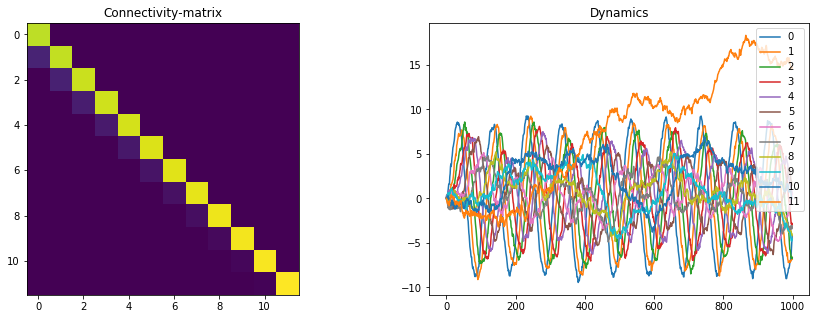

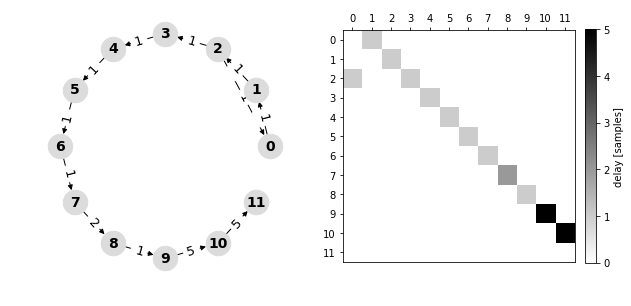

,src,trg,te,lag,p
1,0,1,0.125614,1,0.002
2,1,2,0.143705,1,0.002
0,2,0,0.074012,1,0.002
3,2,3,0.137908,1,0.002
4,3,4,0.121499,1,0.002
5,4,5,0.105216,1,0.002
6,5,6,0.076790,1,0.002
7,6,7,0.062688,1,0.002
8,7,8,0.035240,2,0.002
9,8,9,0.028468,1,0.002


In [4]:
# Plot dynamical system
DS1.plot()

for max_lag, results in zip(maxLagLst, resultsLst):
    print('For max_lag =', max_lag)
    # Plot inferred network to console and via matplotlib
    #results.print_edge_list(weights='max_te_lag', fdr=False)
    plot_network(results=results, weights='max_te_lag', fdr=False)
    plt.show()

    # Print details of TE estimation
    display(parseResults(results, param['N_NODE']))

### 2. STATISTICAL SANITY CHECK

**TODO:**
1. Construct sets: `[lags], [N_NODE], [noise variances], [period lengths]`
2. Subselect reasonable combinations
3. Run code for each
4. For each run, save: `MAT_TE, MAT_DELAY`
5. Compute:
  * Frequency number correct connection = N as function of N
  * Frequency all correct delays are correct
  * Frequency exists fake connect
  * Ratio MAX_FAKE_TE / AVG_REAL_TE, MAX_FAKE_TE / MIN_REAL_TE
  * Number of fake, number of fake within 10% of MAX_FAKE_TE
  * Effect of noise for fixed everything else, max_lag=1 and max_lag=6
  * Effect of period for fixed everything else, max_lag=1 and max_lag=6

In [ ]:
%%time
# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 12,
    'N_DATA'  : 4000,
    'T'       : 100,
    'STD'     : 0.2
}
min_lag, max_lag = 1, 5

##########################
# Datapoint number sweep
##########################
nDataLst = (10**(np.linspace(2, 5, 40))).astype(int)
resultsNDataLst = []

for N_DATA in nDataLst:
    paramThis = np.copy(param)
    paramThis['N_DATA'] = N_DATA
    
    DS1 = DynSys(paramThis)
    resultsNDataLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]
    
##########################
# Period sweep
##########################
TLst = (2**(np.linspace(2, 8, 7))).astype(int)
resultsTLst = []

for T in TLst:
    paramThis = np.copy(param)
    paramThis['T'] = T
    
    DS1 = DynSys(paramThis)
    resultsTLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]
    
##########################
# STD sweep
##########################
STDLst = 0.01 * (10**(np.linspace(0, 2.3, 8))).astype(int)
resultsSTDLst = []

for STD in STDLst:
    paramThis = np.copy(param)
    paramThis['STD'] = STD
    
    DS1 = DynSys(paramThis)
    resultsSTDLst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]
    
##########################
# ALPHA sweep
##########################
ALPHALst = 1 - 0.1**(np.linspace(0.5, 2, 8))
resultsALPHALst = []

for T in TLst:
    paramThis = np.copy(param)
    paramThis['ALPHA'] = ALPHA
    
    DS1 = DynSys(paramThis)
    resultsALPHALst += [parseResults(DS1.computeTE(min_lag, max_lag), paramThis['N_NODE'])]

Adding data with properties: 12 processes, 100 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (4, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 2)]
final target samples: [(5, 1)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), 

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 119 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), 

testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4

testing candidate: (1, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 5), (5, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 5)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

testing candidate: (7, 2) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 4), (7, 2), (2, 3)]
testing candidate: (1, 4) minimum statistic, n_perm: 500
testing candidate: (7, 2) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (7, 2), (2, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 2), (2, 3)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum sta

testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 5)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 203 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (

testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (4, 2), (3, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 3)]
final target samples: [(4, 1), (4, 5), (4, 2)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2)

testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5

testing candidate: (9, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 5)]
final target samples: [(10, 1)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (3, 3) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 3)]
final

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus

testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (7, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 2)]
final target samples: [(8, 1)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3)

testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (1, 2) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 2)]
 -- significant

---------------------------- (4) final stati

testing candidate: (7, 5) maximum statistic, n_perm: 200
testing candidate: (7, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (5, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1)]
omnibus

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7,

testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 5)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 701 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

------------------

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1), (11, 3)]
testing candidate: (11, 3) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1), (11, 3)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1), (11, 3)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum stati

testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 5), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 5)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (6, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (6, 4) maximum statistic, n_perm: 200
testing candidate: (6, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 4)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 4)]
final target samples: [(7, 1), (7, 5)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1), (1, 5)]
testing candidate: (1, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 1), (1, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1), (1, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic,

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1),

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 1193 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum stat

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (9, 2) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 2)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (10, 5), (9, 2)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 2)]
final target samples: [(10, 1), (10, 5)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (8, 1) maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (0, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 5), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 5)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (5, 4)]
testing candidate: (5, 4) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5), (5, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5), (5, 4)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic,

testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

testing candidate: (10, 4) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 4)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (10, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 4)]
final target samples: [(11, 1)]


Adding data with properties: 12 processes, 2894 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum sta

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (9, 5) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 5)]
final target sam

testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus

testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 5), (7, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 5)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

testing candidate: (7, 5) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1)]
omnibus

testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (1, 5

testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus

testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (10, 4), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1), (10, 4)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

testing candidate: (9, 5) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (8, 3) maximum statistic, n_perm: 200
testing candidate: (7, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 3)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 5), (8, 3)]
omnibus

testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final stat

testing candidate: (7, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum st

testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (7, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) p

testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final stati

testing candidate: (10, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (11, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(9, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(10, 1), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n

final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5), (2, 2)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 

testing candidate: (8, 5) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (7, 1) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(7, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (8, 5), (7, 1)]
omnibus

final source samples: [(2, 5), (1, 5), (6, 4), (3, 5), (5, 4)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5),

testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (5, 1) maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(5, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(6, 1), (6, 5), (5, 1)]
omnibus

testing candidate: (10, 1) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(10, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(11, 1), (11, 5), (10, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(10, 1)]
final target samples: [(11, 1), (11, 5)]


Adding data with properties: 12 processes, 14251 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: 

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(8, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(9, 1), (9, 5), (8, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 5)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 4) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (10, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
fina

testing candidate: (6, 1) maximum statistic, n_perm: 200
testing candidate: (10, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1)]
final target samples: [(7, 1), (7, 5)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
testing candidate: (8, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (6, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (1, 5), (3, 5), (5, 5)]
testing candidate: (1, 5) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5), (1, 5), (3, 5), (5, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5), (1, 5), (3, 5), (5, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidat

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

final source samples: [(9, 1)]
final target samples: [(10, 1), (10, 5)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
testing candidate: (11, 2) maximum statistic, n_perm: 200
testing candidate: (11, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (8, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 5)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
testing candidate: (9, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (10, 1), (10, 2), (10, 3), (10,

testing candidate: (0, 1) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (1, 2), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5), (1, 2)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 2 - testing sources [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2)

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(5, 1)]
final target samples: [(6, 1), (6, 5)]



####### analysing target with index 7 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 7 - testing sources [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(7, 1), (7, 2), (7, 3), (7, 4), (7, 5)]
testing candidate: (7, 1) 
maximum statistic, n_perm: 200
testing candidate: (7, 5) maximum statistic, n_perm: 200
testing candidate: (7, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 1), (9, 

Adding data with properties: 12 processes, 34551 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 1), (8, 2), (8, 3), (8,

testing candidate: (5, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]



####### analysing target with index 5 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 5 - testing sources [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
testing candidate: (5, 1) 
maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (5, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4)

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(8, 1)]
final target samples: [(9, 1), (9, 5)]



####### analysing target with index 10 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 10 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

---------------------------- (1) include target candidates
candidate set: [(10, 1), (10, 2), (10, 3), (10, 4), (10, 5)]
testing candidate: (10, 1) 
maximum statistic, n_perm: 200
testing candidate: (10, 5) maximum statistic, n_perm: 200
testing candidate: (10, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8,

testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(6, 1), (2, 1)]
testing candidate: (2, 1) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(7, 1), (7, 5), (6, 1), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(6, 1), (2, 1)]
final target samples: [(7, 1), (7, 5)]



####### analysing target with index 8 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 8 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(8, 1), (8, 2), (8, 3), (8, 4), (8, 5)]
testing candidate: (8, 1) 
maximum statistic, n_perm: 200
testing candidate: (8, 5) maximum statistic, n_perm: 200
testing candidate: (8, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1)

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (5, 5) maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (8, 2) maximum statistic, n_perm: 200
testing candidate: (4, 4) maximum statistic, n_perm: 200
testing candidate: (9, 1) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (1, 5), (3, 5), (5, 5), (6, 5), (8, 2), (4, 4), (9, 1)]
testing candidate: (9, 1) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (0, 2), (2, 5), (1, 5), (3, 5), (5, 5), (6, 5), (8, 2), (4, 4), (9, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final

testing candidate: (4, 1) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(5, 1), (5, 5), (4, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(4, 1)]
final target samples: [(5, 1), (5, 5)]



####### analysing target with index 6 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 6 - testing sources [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
testing candidate: (6, 1) 
maximum statistic, n_perm: 200
testing candidate: (6, 5) maximum statistic, n_perm: 200
testing candidate: (6, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source 

 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(9, 1)]
final target samples: [(10, 1), (10, 5)]



####### analysing target with index 11 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 11 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

---------------------------- (1) include target candidates
candidate set: [(11, 1), (11, 2), (11, 3), (11, 4), (11, 5)]
testing candidate: (11, 1) 
maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
testing candidate: (11, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (11, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 4 - testing sources [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source

omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(7, 1)]
final target samples: [(8, 1), (8, 5)]



####### analysing target with index 9 from list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Target: 9 - testing sources [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

---------------------------- (1) include target candidates
candidate set: [(9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
testing candidate: (9, 1) 
maximum statistic, n_perm: 200
testing candidate: (9, 5) maximum statistic, n_perm: 200
testing candidate: (9, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7

In [ ]:
analysePlotResults(nDataLst, resultsLst, DS1)

In [ ]:
print("Results for nData Sweep:")
analysePlotResults(nDataLst, resultsnDataLst, DS1)
print("Results for Period Sweep:")
analysePlotResults(TLst, resultsTLst, DS1)
print("Results for STD Sweep:")
analysePlotResults(STDLst, resultsSTDLst, DS1)
print("Results for ALPHA Sweep:")
analysePlotResults(ALPHALst, resultsALPHALst, DS1)